In [ ]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [2]:
import plot_utils as pu

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns

from scipy.stats import pearsonr

sns.set_style("darkgrid")
np.random.seed(930525)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)

warnings.simplefilter('once')

%matplotlib inline
%load_ext watermark
%watermark --iversions

seaborn 0.10.1
numpy   1.19.5
pandas  1.1.4



In [4]:
import plot_utils as pu
pu.figure_setup()
clf_name = "rf_feature_selection_et"

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
from glob import glob

import joblib

clf_model = joblib.load("../data/clf.sklearn.all.rf_feature_selection_et.pkl")
clf_log = joblib.load("../data/clf.logistic.all.rf_feature_selection_et.pkl")

In [6]:
X_train, y_train, X_test, y_test = joblib.load("../data/data.pkl")

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
files = glob("/mnt/btrfs/data/type_1/chemo/b6_capitalist_split_by_sample/*.extra.csv")

dfs = []
for file in files:
    name = os.path.basename(file).split('.b6')[0]    
    df = pd.read_csv(file, index_col = 0)
    df['dataset'] = name
    dfs.append(df)
df_assembly_features = pd.concat(dfs)

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (84,88,97,106,218,222,231,240) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (70,83,84,88,95,96,97,100,103,104,106,108,109,204,217,218,222,229,230,231,234,237,238,240,242,243) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (84,88,97,106) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/IPy

In [8]:
df = pd.read_csv("../data/metadata_chemodata_2021.csv", index_col=0)

In [9]:
samples_names = dict([(_.lower().replace(".fastq.gz", "").replace("_", ".").replace(".r1.", ".").replace(".r2.", "."), ix) for _, ix in zip(df['clean'], df['newsamps'])])

In [10]:
depths = df_assembly_features.groupby("dataset")["hits"].sum()
mask = (df_assembly_features.groupby("dataset")["hits"].sum() < 100_000)

In [11]:
mask_dataset = [_ in set(depths[mask].index) for _ in df_assembly_features.dataset]

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
mask_dataset = np.array(mask_dataset)

In [13]:
df_masked = df_assembly_features.loc[~mask_dataset, :]

In [14]:
df_assembly_features = df_masked.copy()

In [15]:
missed = set()
orig_missed = set()
hit = dict()
n_hit = 0
n_missed = 0
for _ in df_assembly_features['dataset']:
    newname = _.lower().replace("_", ".").replace("chemo.", "").replace("k.", "")
    if newname.startswith("p"):
        newname = ".".join(newname.split(".")[:2])
    elif len(newname.split('.')) > 1:
        if newname.split('.')[1].startswith("p"):
            break
        else:
            newname = newname.split(".")[0]
    if not newname in samples_names:
        orig_missed.add(_)
        missed.add(newname)
        n_missed += 1
#         hit[_] = ""
    else:
        hit[_] = samples_names[newname]
        n_hit += 1

In [16]:
df_assembly_features["newsamps"] = df_assembly_features["dataset"].map(hit)

In [17]:
df['mapping'] = df['newsamps'].map(dict([(value, key) for key, value in hit.items()]))

In [18]:
df_filtered = df.loc[~df['mapping'].isna()]

In [19]:
idxs = []
for name, group in df_filtered.groupby('pid'):
    subset = group.loc[group['rel_samp_day_to_txp'] <= 0, 'rel_samp_day_to_txp']
    if len(subset) > 0:
        idxs.append(subset.idxmax())

In [20]:
df_samples = df.loc[idxs]

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
df_assembly_subset = pd.merge(df_assembly_features, df_samples, on="newsamps", how="inner")

In [22]:
df_assembly_subset['relative_abundance'] = df_assembly_subset['hits'] / df_assembly_subset.groupby('dataset')['hits'].transform('sum')

features = ['hits',
 'percent_coverage',
 'mean_coverage',
 'sd_coverage',
 'percent_binned_coverage',
 'mean_binned_coverage',
 'sd_binned_coverage',
 'expected_percent_coverage',
 'shannon_entropy',
 'percent_max_uncovered_region',
 'largest_pileup',
 'largest_binned_pileup',
 'gc_content',
 'total_genome_length',
 'ungapped_genome_length',
 'num_n_groups',
 'consecutive_ns',
 'gf_checkm_completeness',
 'gf_checkm_contamination',
 'relative_abundance',
 'tree_hits',
 'tree_percent_coverage',
 'tree_mean_coverage',
 'tree_sd_coverage',
 'tree_percent_binned_coverage',
 'tree_mean_binned_coverage',
 'tree_sd_binned_coverage',
 'tree_expected_percent_coverage',
 'tree_shannon_entropy',
 'tree_percent_max_uncovered_region',
 'tree_largest_pileup',
 'tree_largest_binned_pileup',
 'tree_dist',
 'tree_top_dist'
]

In [23]:
df_assembly_subset["dataset"].unique().shape

(68,)

In [24]:
y_mod = clf_model.predict(df_assembly_subset[features])

In [25]:
y_log = clf_log.predict(df_assembly_subset[["relative_abundance"]])

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
df_assembly_subset["y_mod"] = y_mod
df_assembly_subset["y_log"] = y_log

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
df_log = df_assembly_subset.loc[df_assembly_subset["y_mod"], :]

In [28]:
# len(set(df_assembly_subset.loc[((df_assembly_subset["y_log"] == False) & (df_assembly_subset["y_mod"])), "assembly_accession"]))

In [29]:
# df_assembly_subset.loc[((df_assembly_subset["y_log"] == False) & (df_assembly_subset["y_mod"])), "mean_percent_coverage"]

In [30]:
df_counts = df_assembly_subset.loc[(df_assembly_subset["y_log"]) | (df_assembly_subset["y_mod"]),:].pivot_table(index='newsamps', columns='assembly_accession', values='hits', fill_value=0)

In [31]:
df_log = df_assembly_subset.loc[df_assembly_subset["y_log"], :].pivot_table(index='newsamps', columns='assembly_accession', values='hits', fill_value=0)

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
(((df_log > 0).sum(axis=0) / df_log.shape[0]) > .1).sum()

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


277

In [33]:
from skbio.stats.composition import multiplicative_replacement, clr
from skbio.stats.composition import ancom
from scipy.stats import mannwhitneyu,ttest_ind
from statsmodels.stats.multitest import fdrcorrection

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/skbio/sequence/_sequence.py:28: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  collections.Sequence, SkbioObject):
/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/skbio/io/format/gff3.py:217: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Iterable


In [34]:
df_mod_filtered = df_counts.loc[:, (((df_counts > 0).sum(axis=0) / df_counts.shape[0]) > .0)]

df_mod_filtered = df_mod_filtered.apply(lambda x: x / x.sum(), axis=1)

df_mod_filtered = pd.DataFrame(multiplicative_replacement(df_mod_filtered), index=df_mod_filtered.index, columns=df_mod_filtered.columns)
df_mod_filtered_clr = pd.DataFrame(clr(df_mod_filtered), index=df_mod_filtered.index, columns=df_mod_filtered.columns)

grouping = df_samples["BSI_infxn_Y_N"]
# grouping = df_samples["NF_Y_N"]

grouping.index = df_samples['newsamps']

mask = np.isfinite(grouping)

df_mod_filtered = df_mod_filtered.loc[mask, :]
df_mod_filtered_clr = df_mod_filtered_clr.loc[mask, :]
grouping = grouping.loc[mask]

df_ancom, df_percentile = ancom(df_mod_filtered, grouping)

statistics = []
pvalues = []
columns = []
lfcs = []
for column in df_mod_filtered.columns:
    x = df_mod_filtered.loc[grouping == 1, column]
    y = df_mod_filtered.loc[grouping == 0, column]
    x_clr = df_mod_filtered_clr.loc[grouping == 1, column]
    y_clr = df_mod_filtered_clr.loc[grouping == 0, column]
    statistic, pvalue = ttest_ind(x_clr, y_clr, alternative="two-sided")
    statistics.append(statistic)
    pvalues.append(pvalue)
    columns.append(column)
    lfcs.append(np.mean(np.log2(x)) - np.mean(np.log2(y)))
    
# _, adj_pvalues = fdrcorrection(pvalues, alpha=.2)

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/scipy/stats/stats.py:3709: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())


In [35]:
df_results = pd.DataFrame(np.array([statistics, pvalues, columns, lfcs]).T, columns=["W", "pvals", "assembly_accession", "log2fc"])

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
s_mod = set(df_assembly_subset.loc[df_assembly_subset["y_mod"], "assembly_accession"])
s_log = set(df_assembly_subset.loc[df_assembly_subset["y_log"], "assembly_accession"])

df_results["in_log"] = [_ in s_log  for _ in df_results["assembly_accession"]]
df_results["in_mod"] = [_ in s_mod  for _ in df_results["assembly_accession"]]

In [37]:
for col in ["W", "pvals", "log2fc"]:
    df_results[col] = df_results[col].astype(float)

In [38]:
df_results

,W,pvals,assembly_accession,log2fc,in_log,in_mod
0,1.109259,0.271603,GCA_000165065.1,0.448977,True,True
1,0.832975,0.408056,GCA_000210015.1,0.857446,True,False
2,-0.970274,0.335680,GCA_000210075.1,-1.718976,True,True
3,-1.360218,0.178686,GCA_000210555.1,-1.985406,True,True
4,-0.312588,0.755643,GCA_000285855.2,-0.609424,True,False
...,...,...,...,...,...,...
1082,-0.201715,0.840800,GCF_900635155.1,-0.222693,True,False
1083,-0.199904,0.842210,GCF_900635425.1,-0.362724,True,True
1084,1.255106,0.214151,GCF_900636475.1,0.587850,True,False
1085,0.986521,0.327712,GCF_900637515.1,0.457476,True,False


In [39]:
_, df_results['adj_pvals'] = fdrcorrection(df_results["pvals"], alpha=.2)

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
cp = sns.color_palette("colorblind")

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
cp_colors = {
    "Baseline": cp[1], 
    "Model": cp[0], 
    "both": cp[2],
    "drop": cp[7],
}

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


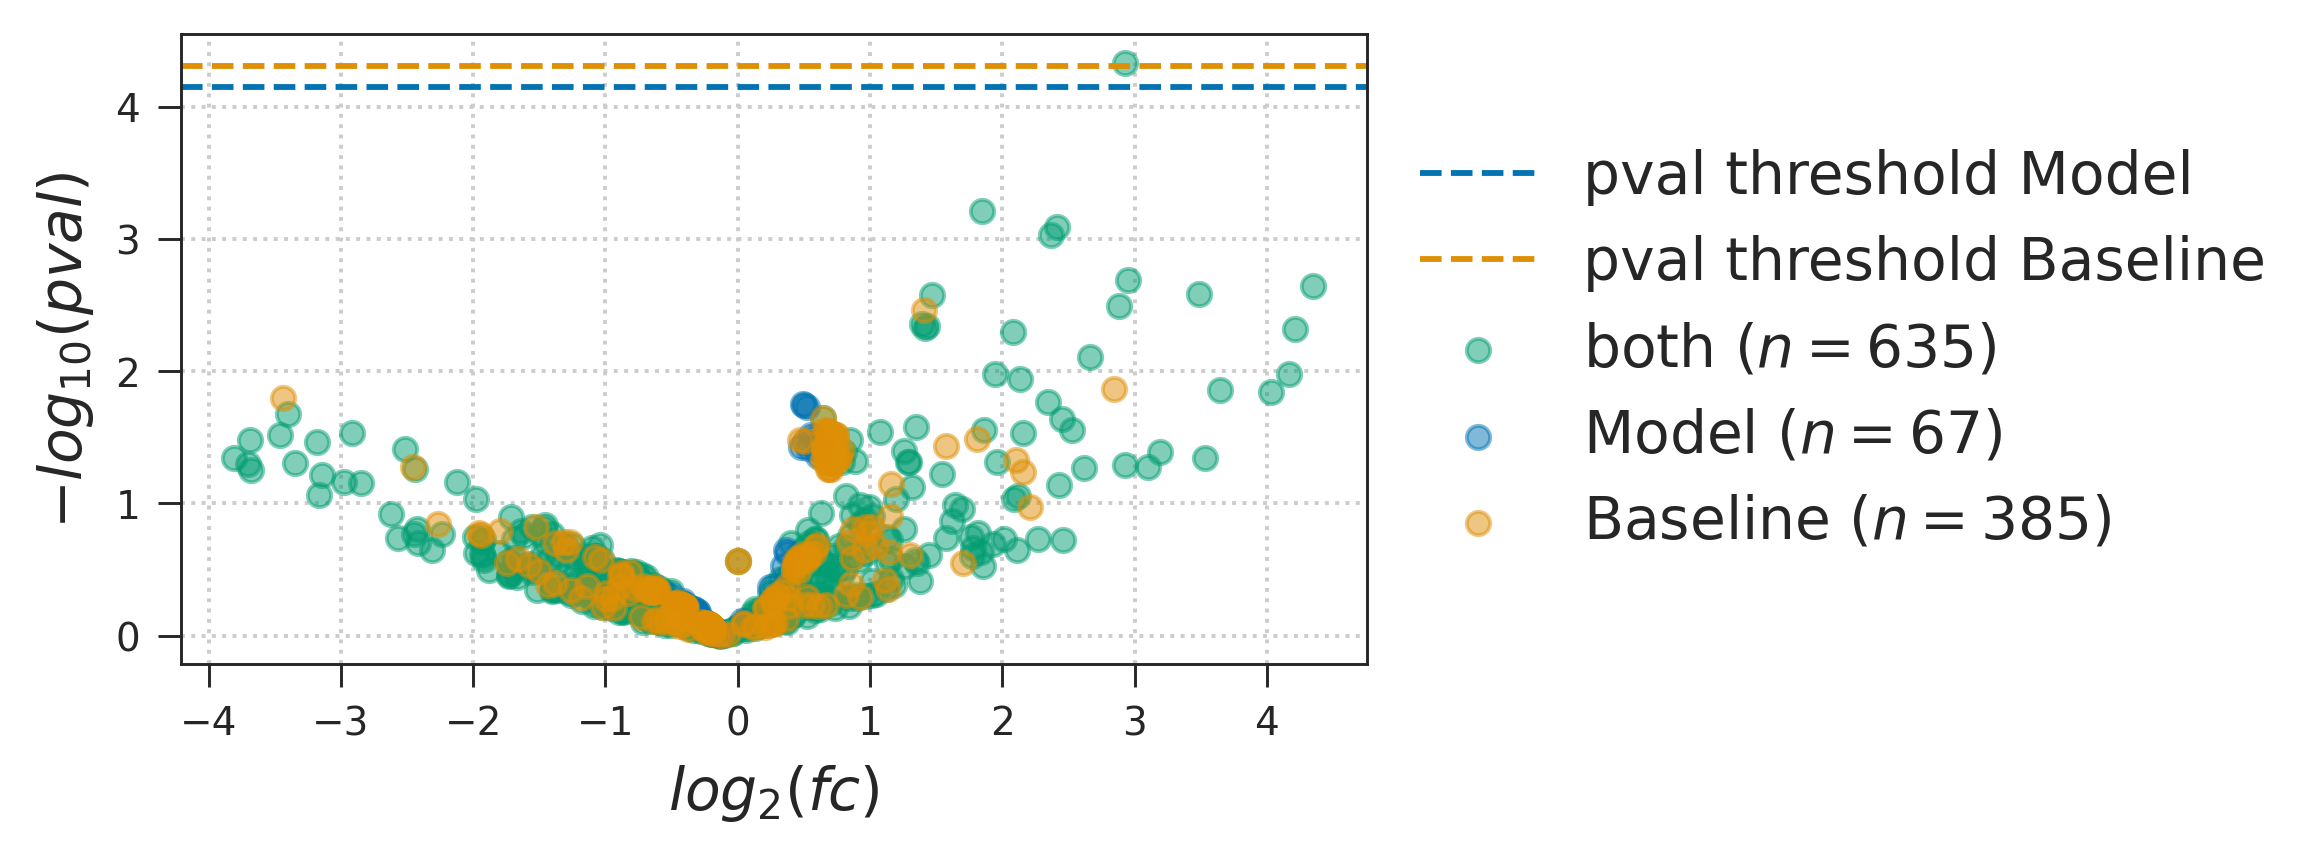

In [76]:
# sns.set(context="paper", style="ticks", palette="colorblind", font='serif', font_scale=1.5, color_codes=True, rc=pu.figure_setup())

colors = np.repeat("both", df_results.shape[0]).astype("object")
colors[df_results['in_mod'] == False] = 'Baseline'
colors[df_results['in_log'] == False] = 'Model'

log_n = df_results.shape[0] - (colors == 'Baseline').sum()
mod_n = df_results.shape[0] - (colors == 'Model').sum()

figsize = pu.get_fig_size(10, 10)
fig, ax = plt.subplots(figsize=figsize)
for color in ["both", "Model", "Baseline"]:
    ax.scatter(df_results.loc[colors == color, "log2fc"], -np.log10(df_results.loc[colors == color, "pvals"]), label=f"{color} $(n={np.sum(colors==color)})$", alpha=.5, color=cp_colors[color])
# sns.scatterplot(df_results["log2fc"], -np.log10(df_results["pvals"]), hue=colors, ax=ax)

ax.axhline(y = -np.log10((.05/log_n)), color = cp[0], linestyle = '--', label="pval threshold Model")
ax.axhline(y = -np.log10((.05/mod_n)), color = cp[1], linestyle = '--', label="pval threshold Baseline")

ax.set_aspect('equal', adjustable='box')

# pu.stylize_axes(ax)
# pu.stylize_fig(fig)
plt.tight_layout()

ax.set_xlabel("$log_2(fc)$")
ax.set_ylabel("$-log_{10}(pval)$")

artists = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
artists.set_frame_on(False)
# ax.legend()
pu.stylize_axes(ax)
pu.stylize_fig(fig)

pu.save_plot(fig, f"volcano_plot", artists=(artists,))

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


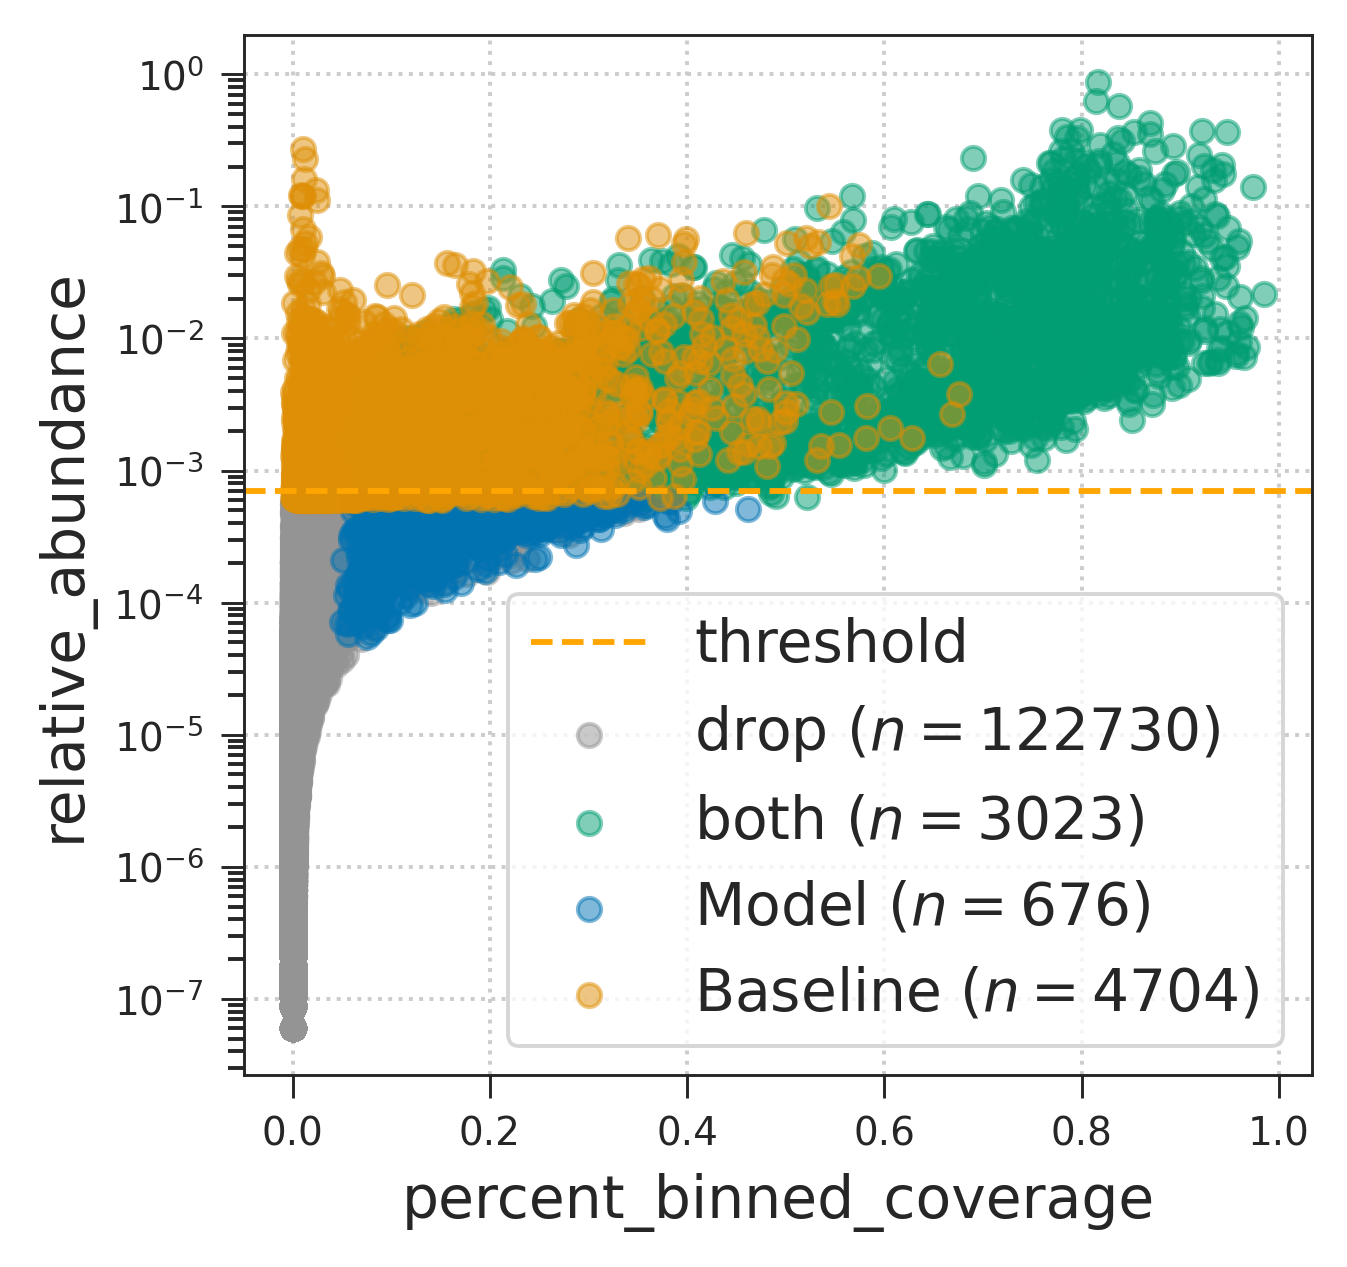

In [80]:
colors = np.repeat("both", df_assembly_subset.shape[0]).astype("object")

colors[df_assembly_subset['y_mod'] == False] = 'Baseline'
colors[df_assembly_subset['y_log'] == False] = 'Model'
colors[(df_assembly_subset['y_log'] == False) & (df_assembly_subset['y_mod'] == False)] = 'drop'

figsize = pu.get_fig_size(10, 10)
fig, ax = plt.subplots(figsize=figsize)
# fig, ax = plt.subplots()
for color in ["drop", "both", "Model", "Baseline"]:
    ax.scatter(df_assembly_subset.loc[colors == color, "percent_binned_coverage"],df_assembly_subset.loc[colors == color, "relative_abundance"], label=f"{color} ($n={np.sum(colors==color)}$)", alpha=.5, color=cp_colors[color])
# sns.scatterplot(df_assembly_subset["percent_binned_coverage"], df_assembly_subset["relative_abundance"], ax=ax)
plt.semilogy()
ax.axhline(y = .0007, color = 'orange', linestyle = '--', label="threshold")

ax.set_xlabel("percent_binned_coverage")
ax.set_ylabel("relative_abundance")
ax.legend()

pu.stylize_axes(ax)
pu.stylize_fig(fig)

pu.save_plot(fig, f"chemo_figure")